# Python Parallel Computing - MPI
Part of this lecture is based on the material by [Dr. Gregory Watson](https://nyu-cds.github.io/python-itertools/)

Lets start with the introductory text by Dr.Gregory Watson about [parallel computing](https://nyu-cds.github.io/python-mpi/01-introduction/).

You need to install:
- open-mpi (brew install open-mpi)
- mpi4py (pip3 install mpi4py)

A more detailed description this [page](https://info.gwdg.de/~ceulig/docs-dev/doku.php?id=en:services:application_services:high_performance_computing:mpi4py) for a more detailed discussion of mpi4py.

---
The most commonly used method of programming distributed-memory multiple instruction, multiple data (MIMD) systems is message passing, being __MPI__ the most widely used standard.

Processes should coordinate their activities by explicitly sending and receiving messages, a mechanism known as __point to point communication__.

MPI operates as follows:
- Process A decides a message needs to be sent to process B.
- Process A packs up all of its necessary data into a buffer for process B.
- Process A indicates that the data should be sent to process B by calling the _Send_ function.
- Process B needs to acknowledge it wants to receive the message by calling the _Recv_ function.

Every time a process sends a message, there must be a process that also indicates it wants to receive the message, therefore, calls to _Send_ and _Recv_ are always paired.

The number of processes is fixed when an MPI program is started and each of the processes is assigned a unique integer starting from 0. This integer is know as the rank of the process and is how each process is identified when sending and receiving messages (we will refer to rank K process as "process K").

MPI processes are arranged in logical collections known as communicators. There is one special communicator that exists when an MPI program starts, which contains all the processes in the MPI program. This communicator is called MPI.COMM_WORLD. In mpi4py, communicators are represented by the __Comm class__.

MPI provides a few methods on a communicator:
- Get_size() - returns the total number of processes contained in the communicator (the size of the communicator).
- Get_rank() - returns the rank of the calling process within the communicator. 
- Send() - sends content to a process
- Recv() - receives content from a process

In [1]:
#####
# I couldn't make mpi4pi work within jupyter notebook
#####

from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
print('size=%d, rank=%d' % (size, rank))

size=1, rank=0


In [2]:
%%writefile mpi1.py
#####
# writting the code in the mpi1.py file
#####

from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
print('size=%d, rank=%d' % (size, rank))

Overwriting mpi1.py


In [2]:
#####
# running MPI from the terminal
#####
!mpiexec -n 2 python3 mpi1.py

size=2, rank=1
size=2, rank=0


---
### One MPI program, multiple MPI processes
Making each process to perform a different computation 

In [5]:
%%writefile mpi2.py

from mpi4py import MPI
rank = MPI.COMM_WORLD.Get_rank()

a = 6.0
b = 3.0
print('Rank',rank)
if rank == 0:
        print(a + b)
if rank == 1:
        print(a * b)
if rank == 2:
        print(max(a,b))
if rank == 3:
        print('doing nothing')

Overwriting mpi2.py


In [8]:
!mpiexec -n 4 python3 mpi2.py

Rank 3
doing nothing
Rank 2
6.0
Rank 0
9.0
Rank 1
18.0


---
### Point-to-point communication
Message passing involves two processes: a sender and a receiver (commands _Send_ and _Recv_).

In [9]:
%%writefile mpi3.py
#####
# Sending a message from one process to another
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Send(randNum, dest=0)

if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        comm.Recv(randNum, source=1)
        print("Process", rank, "received the number", randNum[0])

Overwriting mpi3.py


In [14]:
!mpiexec -n 2 python3 mpi3.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.178558573804
Process 0 received the number 0.178558573804


In [15]:
%%writefile mpi4.py
#####
# Sending a message to a process and receiving a message back
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Send(randNum, dest=0)
        comm.Recv(randNum, source=0)
        print("Process", rank, "received the number", randNum[0], "from process 0")
        
if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        comm.Recv(randNum, source=1)
        print("Process", rank, "received the number", randNum[0], "from process 1")
        randNum *= 2
        comm.Send(randNum, dest=1) 

Overwriting mpi4.py


In [16]:
!mpiexec -n 2 python3 mpi4.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.106723436108
Process 0 received the number 0.106723436108 from process 1
Process 1 received the number 0.213446872217 from process 0


The receiving process does not always need to specify the source when issuing a Recv. Instead, the process can accept any message that is being sent by another process. This is done by setting the source to MPI.ANY_SOURCE.

In [19]:
%%writefile mpi5.py
#####
# Sending a message to a process and receiving a message back from MPI.ANY_SOURCE
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Send(randNum, dest=0)
        comm.Recv(randNum, source=MPI.ANY_SOURCE)
        print("Process", rank, "received the number", randNum[0], "from porcess", MPI.ANY_SOURCE)
        
if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        comm.Recv(randNum, source=MPI.ANY_SOURCE)
        print("Process", rank, "received the number", randNum[0], "from porcess", MPI.ANY_SOURCE)
        randNum *= 2
        comm.Send(randNum, dest=MPI.ANY_SOURCE)

Overwriting mpi5.py


In [21]:
!mpiexec -n 2 python3 mpi5.py

Process 1 drew the number 0.531947317501
Process 0 before receiving has the number 0.0
Process 0 received the number 0.531947317501 from porcess -1
Traceback (most recent call last):
  File "mpi5.py", line 24, in <module>
    comm.Send(randNum, dest=MPI.ANY_SOURCE)
  File "mpi4py/MPI/Comm.pyx", line 272, in mpi4py.MPI.Comm.Send
mpi4py.MPI.Exception: MPI_ERR_RANK: invalid rank
^C


Sometimes there are cases when a process might have to send many different types of messages to another process. Instead of having to go through extra measures to differentiate all these messages, MPI allows senders and receivers to also specify message IDs (known as tags) with the message. The receiving process can then request a message with a certain tag number and messages with different tags will be buffered until the process requests them.

```python
Comm.Send(buf, dest=0, tag=0)
Comm.Recv(buf, source=0, tag=0, status=None)
```

The _status_ can provide useful information
```python
info = MPI.Status()
source = info.Get_source()
tag = info.Get_tag()
count = info.Get_elements()
size = info.Get_count()
```

In [40]:
%%writefile mpi_status.py
#####
# Sending a message from one process to another
#####

##### make the status to work for tomorrow class

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

info = MPI.Status()
    
randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Send(randNum, dest=0)

if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        comm.Recv(randNum, source=1,status=info)
        print("Process", rank, "received the number", randNum[0])
        print(info.Get_source())

Overwriting mpi_status.py


In [41]:
!mpiexec -n 2 python3 mpi_status.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.711688408262
Process 0 received the number 0.711688408262
1


---
### Non-blocking Communication
In the previous examples, the sender and receiver are not able to perform any action when sending or receiving a message, wasting computational times while waiting for the call to complete. __Non-blocking communcation__ avoids this issue by using the _Isend_ and _Irecv_ methods, which start to send and receive operations and then return immediately to continue computation.

The completion of a send or receive operation can be managed using the _Test_, _Wait_, and _Cancel_ methods.


In [42]:
%%writefile mpi6.py
#####
# this code is similar to mpi3.py, but it uses Wait to block the processes
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        req = comm.Isend(randNum, dest=0)
        #req.Wait()
        print('something here')
        
if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        req = comm.Irecv(randNum, source=1)
        req.Wait()
        print("Process", rank, "received the number", randNum[0])

Overwriting mpi6.py


In [43]:
!mpiexec -n 2 python3 mpi6.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.997483186264
something here
Process 0 received the number 0.997483186264


In [47]:
%%writefile mpi7.py
#####
# overlap communication
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1) 

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Isend(randNum, dest=0)
        randNum[0] /= 3.14 # overlap communication
        print("Process", rank, "number in overlap communication =", randNum[0])
        req = comm.Irecv(randNum, source=0)
        req.Wait()
        print("Process", rank, "received the number", randNum[0])

if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        req = comm.Irecv(randNum, source=1)
        req.Wait()
        print("Process", rank, "received the number", randNum[0])
        randNum *= 2
        comm.Isend(randNum, dest=1)

Overwriting mpi7.py


In [46]:
!mpiexec -n 2 python3 mpi7.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.39121768179
Process 1 number in overlap communication = 0.124591618404
Process 0 received the number 0.39121768179
Process 1 received the number 0.124591618404


---
### Problem Decomposition
A central problem when working with MPI is to break the problem into “chunks” to be handled by individual processes.

There are two main ways to decompose a problem: 
- __Domain decomposition:__ Data associated with a problem is split into chunks and each parallel process works on a chunk of the data.
- __Functional decomposition:__ Focus is on the computation rather than on the data. Used when pieces of data require different processing.

#### Example of a domain decompostion with MPI

Hermite interpolation:
<img src="img8.png" alt="Drawing" style="width: 300px;"/>
$$
p(t)=ax^3+bx^2+cx+d\Longrightarrow
\begin{array}{l}
ax_0^3+bx_0^2+cx_0+d = y_0\\
ax_1^3+bx_1^2+cx_1+d = y_1\\
3ax_0^2+2bx_0+c = m_0\\
3ax_1^2+2bx_1+c = m_1
\end{array}
\Longrightarrow
\left[\begin{array}{cccc}
x_0^3 & x_0^2 & x_0 & 1\\
x_1^3 & x_1^2 & x_1 & 1\\
3x_0^2 & 2x_0 & 1 & 0\\
3x_1^2 & 2x_1 & 1 & 0
\end{array}\right]
\left[\begin{array}{c}
a\\
b\\
c\\
d
\end{array}\right]=
\left[\begin{array}{c}
y_0\\
y_1\\
m_0\\
m_1
\end{array}\right]
$$

In [51]:
def hermite(data):
    A = np.zeros((4,4))
    pts = []

    A[0:2]=np.array([np.power(data[0:2],3),np.power(data[0:2],2),data[0:2],np.array([1,1])]).T
    A[2:4]=np.array([3*np.power(data[0:2],2),2*data[0:2],np.array([1,1]),np.array([0,0])]).T
    b = data[2:]
    coefs = np.linalg.solve(A,b)
    t = np.linspace(data[0],data[1],100)
    pts.extend(np.polyval(coefs,t))
    return(pts)

Took 0.776324987411499s
999900


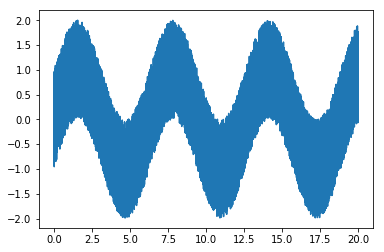

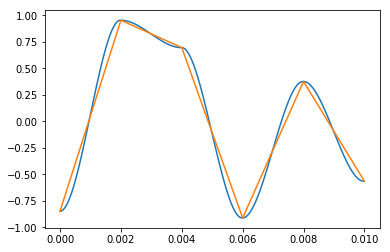

In [181]:
#####
# Finding the piece-wise hermite polynomial interpolation of a set of points
#####
from time import time
import numpy as np
import matplotlib.pyplot as plt

ts = time()
numx = 10000   # number of discretized points in x

x = np.linspace(0,20,numx)
y = np.random.uniform(low=-1,high=1,size=numx)+np.sin(x)
#m = np.random.uniform(low=-1,high=1,size=numx)
m = np.zeros((numx,))
l = []


for i in range(numx-1):
    data = np.array([x[i],x[i+1],y[i],y[i+1],m[i],m[i+1]])
    l.extend(hermite(data))
   
print('Took {}s'.format(time() - ts))
print(len(l))
s = np.linspace(0,20,len(l))
plt.figure(1)
plt.plot(s,l)
plt.figure(2)
plt.plot(s[0:500],l[0:500])
plt.plot(x[0:6],y[0:6])
plt.show()

In [186]:
%%writefile mpi8.py
#####
# Finding the piece-wise hermite polynomial interpolation of a set of points
#####
from time import time
import numpy as np
import matplotlib.pyplot as plt
import numpy
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
status = MPI.Status()

ts = time()
numx = 10000
rank_interva_size = 20/size
numx_per_rank = int(np.floor(numx/size))
m = np.zeros((numx_per_rank,))

def hermite(data):
    A = np.zeros((4,4))
    pts = []

    A[0:2]=np.array([np.power(data[0:2],3),np.power(data[0:2],2),data[0:2],np.array([1,1])]).T
    A[2:4]=np.array([3*np.power(data[0:2],2),2*data[0:2],np.array([1,1]),np.array([0,0])]).T
    b = data[2:]
    coefs = np.linalg.solve(A,b)
    t = np.linspace(data[0],data[1],100)
    pts.extend(np.polyval(coefs,t))
    return(pts)

if rank == 0:
    l = []
    x = np.linspace(0,rank_interva_size,numx_per_rank)
    y = np.random.uniform(low=-1,high=1,size=numx_per_rank)+np.sin(x)
    for i in range(numx_per_rank-1):
        data = np.array([x[i],x[i+1],y[i],y[i+1],m[i],m[i+1]])
        l.extend(hermite(data))
        
    pts = np.zeros((np.asarray(l).shape[0],))
    for p in range(1, size):
        comm.Recv(pts, source=p)
        l.extend(np.ndarray.tolist(pts))
        
    #np.savetxt('mpi_output.dat',np.asarray(l))
else:
    l = []
    x = np.linspace(rank*rank_interva_size,(rank+1)*rank_interva_size,numx_per_rank)
    y = np.random.uniform(low=-1,high=1,size=numx_per_rank)+np.sin(x)
    for i in range(numx_per_rank-1):
        data = np.array([x[i],x[i+1],y[i],y[i+1],m[i],m[i+1]])
        l.extend(hermite(data))
    pts = np.asarray(l) 
    comm.Send(pts,dest=0)
    
print('Took {}s'.format(time() - ts))

Overwriting mpi8.py


In [185]:
!mpiexec -n 4 python3 mpi8.py

Took 0.22076702117919922s
Took 0.23158502578735352s
Took 0.2404930591583252s
Took 0.2515370845794678s


(99600,)


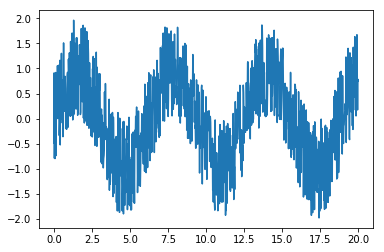

In [175]:
r = np.loadtxt('mpi_output.dat')
print(r.shape)
s = np.linspace(0,20,r.shape[0])
plt.plot(s,r)
plt.show()

---
## Collective Operations: point-to-point vs collective communication

__Collective communication__ allows to send data between multiple processes of a group simultaneously and the most common operations are: 

- Synchronization
  - Processes wait until all members of the group have reached the synchronization point
- Global communication functions
  - Broadcast data from one member to all members of a group
  - Gather data from all members to one member of a group
  - Scatter data from one member to all members of a group
- Collective computation (reductions)
  - One member of the group collects data from the other members and performs an operation (min, max, add, multiply, etc.) on that data.
- Collective Input/Output
  - Each member of the group reads or writes a section of a file.

#### Synchronization
MPI has a special function that is dedicated to synchronizing processes: __comm.Barrier()__. No process advances until all have called the function.
$$
\begin{array}{cc|c}
& \bigcirc & \\
\bigcirc& 	 & \\
& 	\bigcirc & 
\end{array}
\Rightarrow
\begin{array}{cc|c}
& \bigcirc & \\
& \bigcirc	 & \\
& 	\bigcirc & 
\end{array}
\Rightarrow
\begin{array}{cc|c}
& &\bigcirc  \\
& &\bigcirc	  \\
& &	\bigcirc  
\end{array}
$$

#### Broadcasting
One process sends the same data to all processes in a communicator using the command __comm.Bcast(buf, root=0)__.

#### Scatter
Broadcast sends the same piece of data to all processes while scatter sends chunks of an array to different processes. 

__Comm.Scatter(sendbuf, recvbuf, root=0)__ method takes three arguments. The first is an array of data that resides on the root process. The second parameter is used to hold the received data. The last parameter indicates the root process that is scattering the array of data.

#### Gather
Gather is the inverse of scatter, taking elements from many processes and gathering them to one single process.

__Comm.Gather(sendbuf, recvbuf, root=0)__ method takes the same arguments as __Comm.Scatter__.

#### Reduction
__Comm.Reduce(sendbuf, recvbuf, op=MPI.SUM, root=0)__ handles almost all of the common reductions that a programmer needs to do in a parallel application.

__Comm.Reduce__ takes an array of input elements and returns an array of reduced elements to the root process.
- MPI.MAX - Returns the maximum element.
- MPI.MIN - Returns the minimum element.
- MPI.SUM - Sums the elements.
- MPI.PROD - Multiplies all elements.

#### Other Colletive Operations
- __Comm.Alltoall(sendbuf, recvbuf)__
- __File.Open(comm, filename, amode, info)__
- __File.Write_all(buffer)__

---
#### Computing an integral using parallel colletive version 

In [1]:
%%writefile mpi9.py
import numpy
from math import acos, cos
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def integral(a_i, h, n):
    integ = 0.0
    for j in range(n):
        a_ij = a_i + (j + 0.5) * h
        integ += cos(a_ij) * h
    return integ

pi = 3.14159265359
a = 0.0
b = pi / 2.0
dest = 0
my_int = numpy.zeros(1)
integral_sum = numpy.zeros(1)

# Initialize value of n only if this is rank 0
if rank == 0:
    n = numpy.full(1, 500, dtype=int) # default value
else:
    n = numpy.zeros(1, dtype=int)

# Broadcast n to all processes
print("Process ", rank, " before n = ", n[0])
comm.Bcast(n, root=0)
print("Process ", rank, " after n = ", n[0])

# Compute partition
h = (b - a) / (n * size) # calculate h *after* we receive n
a_i = a + rank * h * n
my_int[0] = integral(a_i, h, n[0])

# Send partition back to root process, computing sum across all partitions
print("Process ", rank, " has the partial integral ", my_int[0])
comm.Reduce(my_int, integral_sum, MPI.SUM, dest)

# Only print the result in process 0
if rank == 0:
    print('The Integral Sum =', integral_sum[0])

Overwriting mpi9.py


In [2]:
!mpiexec -n 4 python3 mpi9.py

Process  0  before n =  500
Process  1  before n =  0
Process  2  before n =  0
Process  3  before n =  0
Process  0  after n =  500
Process  2  after n =  500
Process  1  after n =  500
Process  3  after n =  500
Process  0  has the partial integral  0.382683442201
Process  2  has the partial integral  0.216772756896
Process  3  has the partial integral  0.0761204694451
Process  1  has the partial integral  0.32442335716
The Integral Sum = 1.0000000257


### Communication of buffer-like objects
When using the upper case version of the methods (Send, Irecv, Gather, etc.) the data object must support the single-segment buffer interface. This interface is a standard Python mechanism provided by some types (e.g., strings and numeric arrays), which is why we have been using NumPy arrays in the examples.

### Communication of generic Python objects
It is also possible to transmit an arbitrary Python data type using the lower case version of the methods (send, irecv, gather, etc.) mpi4py will serialize the data type, send it to the remote process, then deserialize it back to the original data type (a process known as pickling and unpickling). While this is simple, it also adds significant overhead to the MPI operation.